In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt

In [2]:
class Image_Stitching():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.SIFT_create()
        self.smoothing_window_size=800

    def registration(self, img1, img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches = []
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.title('Matching')
        plt.show()
        if len(good_points) > self.min_match:
            image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
        return H

    def create_mask(self, img1, img2, version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self, img1, img2):
        H = self.registration(img1, img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1, img2, version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1, img2, version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
        result = panorama1 + panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result

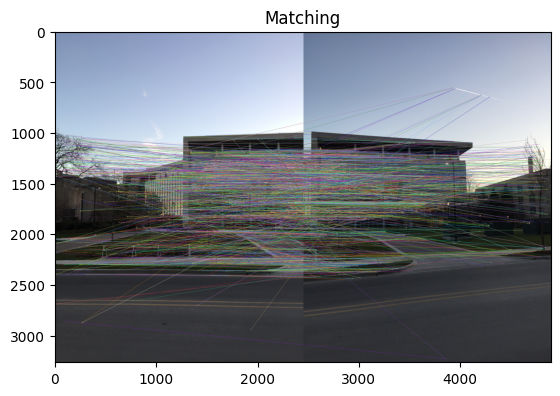

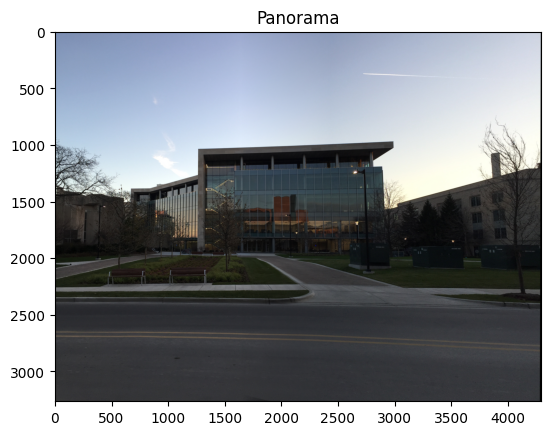

In [3]:
# Load images
img1_path = 'image1.jpg'
img2_path = 'image2.jpg'

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Perform stitching
stitcher = Image_Stitching()
final = stitcher.blending(img1, img2)

# Normalize and convert to 8-bit unsigned integer format
final = cv2.normalize(final, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Save and display the result
cv2.imwrite('panorama.jpg', final)
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.title('Panorama')
plt.show()